<a href="https://colab.research.google.com/github/wtergan/openai-to-z-amazon/blob/main/Checkpoint_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Checkpoint 1: Remote Sensing Analysis with LLMs**

This notebook provides a complete workflow to analyze remote sensing data using an LLM. It supports two data types:
1. **LiDAR Elevation Data:** Fetched from the OpenTopography API.
2. **Sentinel-2 Multispectral Imagery:** Fetched and processed using Google Earth Engine (GEE).

This process for each is:
1. **Fetch Data:** Process the data to generate key statistics (e.g., elevation stats, NDVI) and a visual thumbnail image.
2. **Prompt LLM:** Send the statistics and the image to a multi-modal LLM (OpenAI, OpenRouter API for added model compatibility) for a plain-English interpretation.

### Installing Dependencies:
All the necessary python libraries and packages for usage.

In [1]:
!pip install -q numpy laspy rasterio matplotlib earthengine-api openai python-dotenv requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 29.7 MB/s eta 0:00:00


### **Importing Libraries**
Importing all the libraries needed for the workflow.

In [2]:
import os
import json
import base64
import io
import requests
import tempfile
import urllib
from typing import Dict, Optional, Any

import ee
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
from PIL import Image
from pprint import pprint
from getpass import getpass

# Suppress a specific noisy warning from rasterio in Colab/Jupyter environments
import warnings
warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)

### **API Keys and Environemnt Setup**
Providng required API keys for usage:
1. **OPENAI_API_KEY**: For calling a OpenAI LLM.
2. **OPENROUTER_API_KEY:** For calling a OpenRouter LLM.
3. **OT_API_KEY:** For fetching LiDAR data. Get one from OpenTopography.org. It's optional (for now) if only using Sentinel-2.
4. **GEE_PROJECT_ID:** A required Google Cloud Project ID that is enabled for Earth Engine. This is optional but highly recommended for managing quotas.

In [3]:
# ===============================================================================
# API KEY CONFIGURATION
# ===============================================================================
# Usage of getpass to securely input keys without hardcoding them in the notebook.
try:
    OPENAI_API_KEY = os.environ['OPENAI_API_KEY']
    print("Found OPENAI_API_KEY in environment variables.")
except KeyError:
    OPENAI_API_KEY = getpass('Enter your OpenAI API Key: ')

try:
    OPENROUTER_API_KEY = os.environ['OPENROUTER_API_KEY']
    print("Found OPENROUTER_API_KEY in environment variables.")
except KeyError:
    OPENROUTER_API_KEY = getpass('Enter your OpenRouter API Key: ')

try:
    OT_API_KEY = os.environ['OT_API_KEY']
    print("Found OT_API_KEY in environment variables.")
except KeyError:
    OT_API_KEY = getpass('Enter your OpenTopography API Key (optional): ')

try:
    GEE_PROJECT_ID = os.environ['GEE_PROJECT_ID']
    print(f"Found GEE_PROJECT_ID in environment variables: {GEE_PROJECT_ID}")
except KeyError:
    GEE_PROJECT_ID = input('Enter your GEE Project ID (optional, press Enter to skip): ')
    if not GEE_PROJECT_ID:
        GEE_PROJECT_ID = None

Enter your OpenAI API Key: ··········
Enter your OpenRouter API Key: ··········
Enter your OpenTopography API Key (optional): ··········
Enter your GEE Project ID (optional, press Enter to skip): amazon-env


### Core Defaults: Global Coordinates, Helper Functions
For this checkpoint, going to use a predefined area in the Amazon: a region covering Borba, Amazonas and the Rio Canumã. Will use this region's BBox coordinates thoughout the rest of the notebook.

In addition, some main utility functions that will also be used throughout the rest of the notebook, such as Google Earth Engine initialization, LLM API call functions.

In [4]:
# ===============================================================================
# DEFAULT BBOX COORDINATES: REGION COVERING BORBA AND THE RIO CANUMA
# ===============================================================================
DEFAULT_SOUTH = -5.253821
DEFAULT_NORTH = -3.983349
DEFAULT_WEST = -59.813892
DEFAULT_EAST = -58.332325
DEFAULT_START_DATE = "2023-01-01"
DEFAULT_END_DATE = "2023-12-31"

gee_initialized_successfully = False

# --- GEE Initialization ---
def initialize_gee():
    """Authenticates and initializes the GEE client."""
    global gee_initialized_successfully
    if gee_initialized_successfully:
        print("GEE is already initialized.")
        return True
    try:
        print("Attempting GEE initialization...")
        # First, try to initialize without authentication, assuming credentials exist.
        ee.Initialize(project=GEE_PROJECT_ID, opt_url='https://earthengine-highvolume.googleapis.com')
        print("GEE initialized successfully using existing credentials.")
        gee_initialized_successfully = True
    except ee.EEException:
        print("GEE credentials not found. Starting authentication flow...")
        try:
            # If initialization fails, run the authentication flow.
            ee.Authenticate()
            ee.Initialize(project=GEE_PROJECT_ID, opt_url='https://earthengine-highvolume.googleapis.com')
            print("GEE authenticated and initialized successfully.")
            gee_initialized_successfully = True
        except Exception as e_auth:
            print(f"CRITICAL: GEE authentication and initialization failed: {e_auth}")
            gee_initialized_successfully = False
    return gee_initialized_successfully

In [5]:
# ===============================================================================
# API MODEL USAGE: OpenRouter API
# ===============================================================================
def call_model_responses(
    analysis_results: dict,
    dataset_type: str,
    model_name: str = "google/gemma-3-27b-it", # Default OpenRouter model for now
    temperature: float = 1.0,
    max_tokens: int = 32768,
    **kwargs
) -> str:
    """
    Sends analysis results to OpenRouter API and returns a plain-English description.
    """
    if not OPENROUTER_API_KEY:
        return "[OpenRouter error] API key missing."

    headers = {
        "Authorization": f"Bearer {OPENROUTER_API_KEY}",
        "Content-Type": "application/json",
        "HTTP-Referer": "https://github.com/your-repo", # Optional but good practice
        "X-Title": "Remote Sensing Analysis" # Optional
    }

    # Dynamic prompting scheme based on the data type:
    if dataset_type == 'lidar':
        prompt_intro = ("Here are statistics and a hillshade plot derived from LiDAR elevation data. "
                        "The plot shows elevation on the left and a shaded relief view on the right.")
    else: # sentinel2
        prompt_intro = ("Here are statistics and an RGB thumbnail from a Sentinel-2 satellite median composite. "
                        "The stats include various spectral bands and a calculated NDVI (vegetation index).")

    # Conditionally build the content list for the user message; text input, with image(s) if available:
    user_content = [
        {
            "type": "text",
            "text": (f"{prompt_intro}\n\n"
                     f"Statistics:\n{json.dumps(analysis_results.get('statistics', {}), indent=2)}\n\n"
                     "Please analyze the provided image and statistics. As an expert archaeologist and remote sensing analyst, "
                     "describe the key features, patterns, and anomalies in the landscape in plain English.")
        }
    ]

    if analysis_results.get("image"):
        user_content.append({
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{analysis_results['image']}"
            }
        })

    messages = [
        {
            "role": "system",
            "content": ("You are an expert archaeologist and remote sensing analyst. Your task is to interpret geospatial data. "
                        "You provide clear, insightful, and concise interpretations based on the data provided.")
        },
        {
            "role": "user",
            "content": user_content
        }
    ]

    data = {
        "model": model_name,
        "messages": messages,
        "temperature": temperature,
        "max_tokens": max_tokens,
    }

    try:
        print(f"Sending request to OpenRouter API for model: {model_name}...")
        resp = requests.post("https://openrouter.ai/api/v1/chat/completions", headers=headers, json=data, timeout=120)
        print(f"Response recieved from OpenRouter API:", {resp.status_code})
        resp_json = resp.json()
        if resp.status_code != 200:
            # Return the full error message from the API if available:
            return f"[OpenRouter API error] {resp_json.get('error', resp.text)}"
        if "choices" not in resp_json:
            # Log the full response for debugging:
            return f"[OpenRouter API error] Unexpected response format: {json.dumps(resp_json, indent=2)}"
        response_text = resp_json["choices"][0]["message"]["content"].strip()
        print(f"OpenRouter API usage: {resp_json.get('usage', 'unknown')}")
        return response_text
    except Exception as e:
        return f"[OpenRouter API error] {str(e)}"
    else:
        return f"[Provider error] Unknown provider: {provider}"

In [ ]:
# ===============================================================================
# API MODEL USAGE: OpenAI API
# ===============================================================================
def call_model_responses(
    analysis_results: dict,
    dataset_type: str,
    model_name: str = "gpt-4o-mini",
    temperature: float = 1.0,
    max_tokens: int = 32768,
    **kwargs
) -> str:
    """
    Sends analysis results to OpenAI API and returns a plain-English description.
    """
    if not OPENAI_API_KEY:
        return "[OpenAI error] API key missing."
    # Dynamic prompting scheme based on the data type (matching OpenRouter format):
    if dataset_type == 'lidar':
        prompt_intro = ("Here are statistics and a hillshade plot derived from LiDAR elevation data. "
                    "The plot shows elevation on the left and a shaded relief view on the right.")
    else: # sentinel2
        prompt_intro = ("Here are statistics and an RGB thumbnail from a Sentinel-2 satellite median composite. "
                    "The stats include various spectral bands and a calculated NDVI (vegetation index).")

    # Conditionally build the content list for the user message; input_text, with input_image if available:
    user_content = [
        {
            "type": "input_text",
            "text": (f"{prompt_intro}\n\n"
                        f"Statistics:\n{json.dumps(analysis_results.get('statistics', {}), indent=2)}\n\n"
                        "Please analyze the provided image and statistics. As an expert archaeologist and remote sensing analyst, "
                        "describe the key features, patterns, and anomalies in the landscape in plain English.")
        }
    ]

    if analysis_results.get("image"):
        user_content.append({
            "type": "input_image",
            "image_url": f"data:image/jpeg;base64,{analysis_results['image']}"
        })

    # Instructions for system role/behavior; for response API, this replaces the traditional "system" message role:
    instructions = ("You are an expert archaeologist and remote sensing analyst. Your task is to interpret geospatial data. "
                    "You provide clear, insightful, and concise interpretations based on the data provided.")

    user_message = {
        "role": "user",
        "content": user_content
    }

    try:
        print(f"Sending request to OpenAI Responses API for model: {model_name}...")
        response = client.responses.create(
            model=model_name,
            instructions=instructions,
            input=[user_message],
            temperature=temperature,
            max_output_tokens=max_tokens,
            **kwargs
        )
        print(f"Response received from OpenAI Responses API")
        if not hasattr(response, 'output_text') or response.output_text is None:
            return f"[OpenAI API error] Unexpected response format: {response}"
        if hasattr(response, 'usage'):
            print(f"OpenAI API usage: {response.usage}")
        return response.output_text.strip()
    except OpenAIError as e:
        # This is a more specific error type for OpenAI API errors:
        return f"[OpenAI API error] {str(e)}"
    except Exception as e:
        return f"[OpenAI API error] {str(e)}"

### Workflow Selection
The main control center: Choose which workflow to run via setting DATASET_TYPE
1. 'lidar': To analyze LiDAR elevation data
2. 'sentinel2': To analyze Sentinel-2 satellite imagery.

In [6]:
# ==============================================================================
# CHOOSE YOUR WORKFLOW
# ==============================================================================
DATASET_TYPE = 'lidar'  # <-- CHANGE THIS TO 'lidar' or 'sentinel2'
# ==============================================================================

# Optional: Set to True to have plots/thumbnails pop up in your default image viewer
SHOW_PLOTS_INTERACTIVELY = True

### Workflow 1: LIDAR Data Analysis
The code needed for fetching and analyzing LIDAR data from the OpenTopography API, as well as its execution.

In [7]:
# ==============================================================================
# WORKFLOW 1: LiDAR DATA FETCH, FEATURE EXTRACTION
# ==============================================================================
def fetch_lidar_ot_data(south: float, north: float, west: float, east: float) -> Optional[str]:
    """
    Download a small LiDAR .tif file from OpenTopography API.
    Takes in the available global raster dataset type (demtype), the bbox coordinates,
    and the name to save the file as.
    """
    print("Fetching LiDAR data from OpenTopography...")
    url = "https://portal.opentopography.org/API/globaldem"
    params = {
        "demtype": "COP30", # Copernicus DEM GLO-30
        "south": south, "north": north, "west": west, "east": east,
        "outputFormat": "GTiff", "API_Key": OT_API_KEY
    }
    try:
        tf = tempfile.NamedTemporaryFile(suffix=".tif", delete=False)
        resp = requests.get(url, params=params, timeout=120)
        resp.raise_for_status()
        tf.write(resp.content)
        tf.close()
        print(f"LiDAR data successfully downloaded to temporary file: {tf.name}")
        return tf.name
    except Exception as e:
        print(f"Error fetching LiDAR data: {e}")
        return None

def lidar_ot_extract_features(lidar_path: str, show_image: bool) -> Optional[Dict[str, Any]]:
    """
    Generate and display a plots of LiDAR GeoTIFF data along with some stats.
    Returns a dict containing the plot as a BytesIO obj, and the stats.
    Cleans up the temporary lidar_path file upon completion or error.
    """
    print("Extracting features from LiDAR data...")
    try:
        with rasterio.open(lidar_path) as src:
            lidar_arr = src.read(1).astype(np.float32)
            if src.nodata is not None:
                lidar_arr = np.where(lidar_arr == src.nodata, np.nan, lidar_arr)
            if np.all(np.isnan(lidar_arr)):
                print("Error: LiDAR data is empty or all NoData values.")
                return None

            # Usage of 2-98 percentiles for avoiding outliers that mai affect color mapping:
            vmin, vmax = np.nanpercentile(lidar_arr, [2, 98])

            # Figure with subplots:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
            fig.suptitle("LiDAR Data Analysis", fontsize=16)

            # Main elevation plot
            print("Generating LiDAR elevation plot...")
            im1 = ax1.imshow(lidar_arr, cmap='terrain', vmin=vmin, vmax=vmax)
            plt.colorbar(im1, ax=ax1, label='Elevation (m)')
            ax1.set_title("LiDAR Elevation Data (2-98% range)")

            # Hillshade for better terrain visualization, using LightSource for azimuth and altitude:
            print("Generating LiDAR hillshade...")
            ls = LightSource(azdeg=315, altdeg=45)
            hillshade = ls.hillshade(lidar_arr, vert_exag=1, dx=src.res[0], dy=src.res[1], fraction=1.0)
            ax2.imshow(hillshade, cmap='gray', alpha=0.8)
            ax2.set_title("Hillshade Visualization")

            # Show the plot if show_image is True:
            print("Displaying the plot(s)...")
            if show_image:
                plt.show()

            # Save plot to BytesIO buffer as JPEG, tight bbox, 150 DPI:
            print("Saving plot to BytesIO buffer...")
            buf = io.BytesIO()
            plt.tight_layout()
            plt.savefig(buf, format="JPEG", bbox_inches="tight", dpi=150)
            plt.close(fig)
            buf.seek(0)

            # Binary to base64 conversion:
            print("Converting plot to base64 and computation of stats...")
            image_base64 = base64.b64encode(buf.getvalue()).decode('utf-8')

            # Compile results
            ot_stats = {
                "image": image_base64,
                "statistics": {
                    "mean": float(np.nanmean(lidar_arr)), "median": float(np.nanmedian(lidar_arr)),
                    "std": float(np.nanstd(lidar_arr)), "min": float(np.nanmin(lidar_arr)),
                    "max": float(np.nanmax(lidar_arr)), "percentile_2": float(vmin),
                    "percentile_98": float(vmax), "shape": lidar_arr.shape
                },
                "crs": str(src.crs) if src.crs else "N/A",
                "bounds": list(src.bounds)
            }
            buf.close()
            print("Feature extraction complete.")
            return ot_stats
    except Exception as e:
        print(f"Error extracting LiDAR features: {e}")
        return None
    finally:
        # Clean up the temporary file:
        if os.path.exists(lidar_path):
            os.unlink(lidar_path)
            print(f"Temporary file {lidar_path} deleted.")

Starting LiDAR Workflow...
Fetching LiDAR data from OpenTopography...
LiDAR data successfully downloaded to temporary file: /tmp/tmpdsbflf8n.tif
Extracting features from LiDAR data...
Generating LiDAR elevation plot...
Generating LiDAR hillshade...
Displaying the plot(s)...


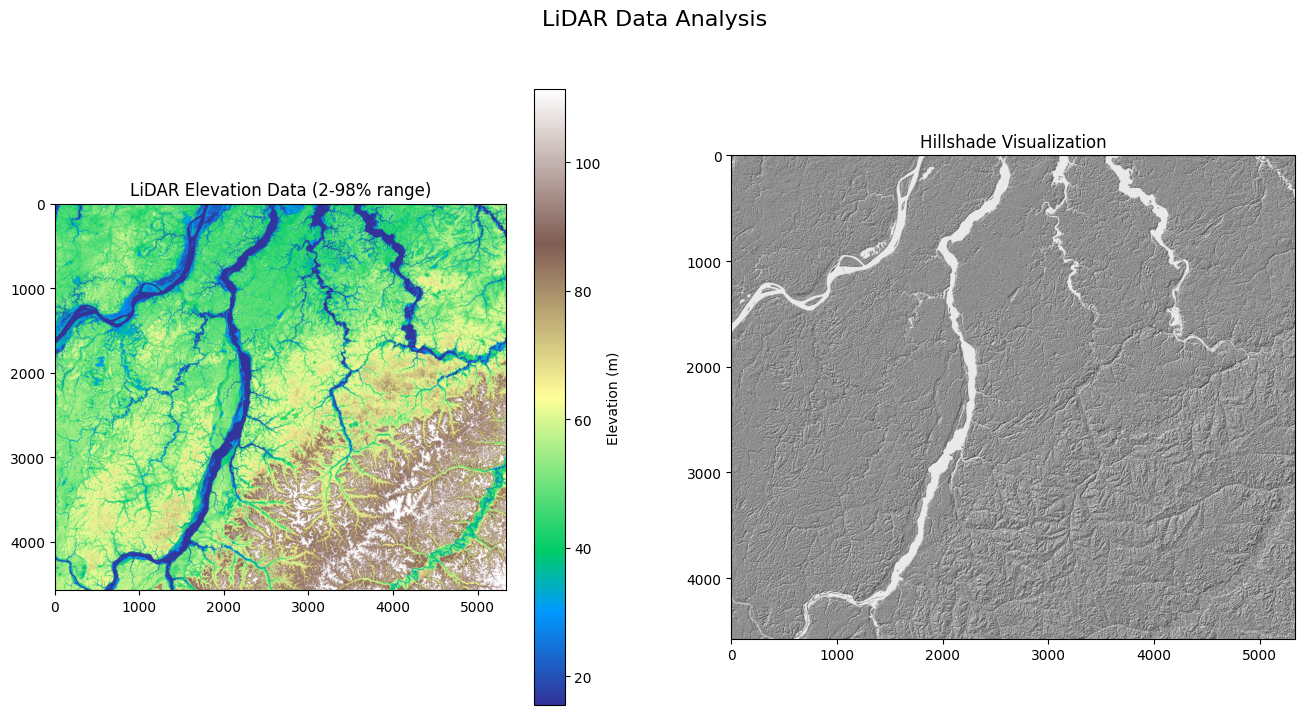

Saving plot to BytesIO buffer...
Converting plot to base64 and computation of stats...
Feature extraction complete.
Temporary file /tmp/tmpdsbflf8n.tif deleted.

--- LiDAR Analysis Statistics ---
{'bounds': [-59.81402778888888,
            -5.253749988888893,
            -58.33236112222221,
            -3.9831944333333382],
 'crs': 'EPSG:4326',
 'statistics': {'max': 193.75477600097656,
                'mean': 57.32450485229492,
                'median': 53.55116653442383,
                'min': 9.088830947875977,
                'percentile_2': 15.5,
                'percentile_98': 111.41586303710938,
                'shape': (4574, 5334),
                'std': 21.870689392089844}}

--- Calling LLM for Interpretation ---
Sending request to OpenRouter API for model: google/gemma-3-27b-it...
Response recieved from OpenRouter API: {200}
OpenRouter API usage: {'prompt_tokens': 561, 'completion_tokens': 540, 'total_tokens': 1101}

--- LLM Interpretation ---
## LiDAR Data Analysis: Landsc

<Figure size 640x480 with 0 Axes>

In [8]:
# ===============================================================================
# WORKFLOW 1: EXECUTION
# ===============================================================================
if DATASET_TYPE == 'lidar':
    print("Starting LiDAR Workflow...")

    # 1. Fetch Data:
    lidar_filepath = fetch_lidar_ot_data(
        south=DEFAULT_SOUTH, north=DEFAULT_NORTH,
        west=DEFAULT_WEST, east=DEFAULT_EAST
    )

    if lidar_filepath:
        # 2. Extract Features:
        analysis_results = lidar_ot_extract_features(lidar_filepath, show_image=SHOW_PLOTS_INTERACTIVELY)

        if analysis_results:
            # 3. Display Statistics:
            print("\n--- LiDAR Analysis Statistics ---")
            stats_to_display = {k: v for k, v in analysis_results.items() if k != 'image'}
            pprint(stats_to_display)

            # 4. Prompt LLM:
            print("\n--- Calling LLM for Interpretation ---")
            summary = call_model_responses(analysis_results, dataset_type='lidar')
            print("\n--- LLM Interpretation ---")
            print(summary)

    print("\n--- LiDAR Workflow Finished ---")

### Workflow 2: Sentinel-2 Data Analysis
The code needed for fetching and analyzing Sentinel-2 data from the Google Earth Engine (GEE), as well as its execution.

In [9]:
# ==============================================================================
# CHOOSE YOUR WORKFLOW
# ==============================================================================
DATASET_TYPE = 'sentinel2'  # <-- CHANGE THIS TO 'lidar' or 'sentinel2'
# ==============================================================================

# Optional: Set to True to have plots/thumbnails pop up in your default image viewer
SHOW_PLOTS_INTERACTIVELY = True

In [13]:
# ==============================================================================
# WORKFLOW 2: SENTINEL-2 DATA FETCH, FEATURE EXTRACTION
# ==============================================================================
def cloud_mask_s2_sr(image: ee.Image) -> ee.Image:
    """Applies a cloud mask to a Sentinel-2 SR image using the SCL band."""
    scl = image.select('SCL')
    # Mask out cloud shadow, medium/high probability cloud, and cirrus
    clear_mask = scl.neq(3).And(scl.neq(8)).And(scl.neq(9)).And(scl.neq(10))
    # Also mask out saturated/defective pixels and ensure valid data
    valid_data_mask = image.select('B2').gt(0).And(scl.neq(1))
    # Scale factor for SR is 10000
    return image.updateMask(clear_mask.And(valid_data_mask)).divide(10000)

def fetch_sentinel2_gee_data(south: float, north: float, west: float, east: float, start_date: str, end_date: str,
                             max_cloud_percentage: float = 20.0) -> Optional[Dict[str, Any]]:
    """
    Fetching Sentinel-2 L2A median composite from GEE for a given bbox and date range.
    Returns a dictionary containing the GEE image object and ROI.
    """
    print("Fetching and processing Sentinel-2 data from GEE...")
    roi = ee.Geometry.Rectangle([west, south, east, north])
    try:
        s2_collection = (
            ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
            .filterBounds(roi)
            .filterDate(ee.Date(start_date), ee.Date(end_date))
            .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", max_cloud_percentage))
        )
        count = s2_collection.size().getInfo()
        if count == 0:
            print(f"Warning: No Sentinel-2 images found for the given criteria in GEE.")
            print(f"ROI: {west},{south},{east},{north}")
            print(f"Date: {start_date} to {end_date}, Cloud %: < {max_cloud_percentage}")
            return {"image": None, "roi": roi, "count": 0, "error": "No images found"}
        print(f"Found {count} Sentinel-2 images. Creating median composite...")

        # Creating median composite via applying cloud/valid mask, selecting defined bands, and clipping to ROI:
        composite_image = s2_collection.map(cloud_mask_s2_sr).select(['B2', 'B3', 'B4', 'B8']).median().clip(roi)

        # Verify the composite isn't empty
        composite_image.bandNames().getInfo()

        print("Sentinel-2 GEE median composite created.")
        return {
            "image": composite_image, "roi": roi, "count": count,
            "start_date": start_date, "end_date": end_date,
            "roi_bounds": [west, south, east, north]
        }
    except Exception as e:
        print(f"Error fetching/processing GEE data: {e}")
        return None

def sentinel2_gee_extract_features(gee_data: dict, show_image: bool, scale: int = 30, thumb_dimensions: str = '768x768') -> Optional[Dict[str, Any]]:
    """
    Computing stats and generating a thumbnail for a Sentinel-2 GEE Image.
    Expects a dictionary from fetch_sentinel2_gee_data.
    Returns a dict containing the plot as base64, as well as pertinent stats.
    """
    print("Extracting features from GEE composite...")
    try:
        image, roi, roi_bounds = gee_data["image"], gee_data["roi"], gee_data["roi_bounds"]
        # Creating a composite reducer that computes multiple stats all in one operation:
        reducers = (
            ee.Reducer.mean().unweighted().combine(ee.Reducer.minMax().unweighted(), "", True)
            .combine(ee.Reducer.stdDev().unweighted(), "", True)
            .combine(ee.Reducer.percentile([2, 98]).unweighted(), "", True)
            .combine(ee.Reducer.count().unweighted(), "", True)
        )
        selected_bands = ['B2', 'B3', 'B4', 'B8']

        try:
        # Computation of the stats for each selected band, given image, ROI, scale, and reducers:
            print(f"Calculating stats for bands: {selected_bands} at {scale}m scale...")
            band_stats = image.select(selected_bands).reduceRegion(
                reducer=reducers, geometry=roi, scale=scale, maxPixels=1e10, tileScale=4
            ).getInfo()
            print("Band stats recieved.")
        except ee.EEException as e:
            print(f"GEE Error calculating band stats: {e}")
            return {
                "image": None,
                "statistics": {"error": f"GEE band stats error: {e}"},
                "roi_bounds": roi_bounds,
                "gee_image_details": f"Error calculating band stats: {e}"
            }

        # Calculating NVDI and its stats:
        ndvi_stats = {}
        try:
            print("Computing Normalized Difference Vegetation Index (NDVI)...")
            ndvi_image = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
            ndvi_stats_raw = ndvi_image.reduceRegion(
                reducer=reducers, geometry=roi, scale=scale, maxPixels=1e10, tileScale=4).getInfo()
            print("NDVI stats recieved.")
            for key, value in ndvi_stats_raw.items():
                ndvi_stats[f"NDVI_{key}"] = value
        except ee.EEException as e:
            print(f"GEE Error calculating NDVI stats: {e}")

        # Merging the stats from all bands and NDVI:
        all_stats = {}
        for band in selected_bands:
            for stat_key, reducer_key_part in {
                "mean": "mean", "min": "min", "max": "max", "std": "stdDev",
                "p2": "p2", "p98": "p98", "count": "count" }.items():
                gee_key = f"{band}_{reducer_key_part}"
                all_stats[f"{band}_{stat_key}"] = band_stats.get(gee_key)
        all_stats.update(ndvi_stats)

        # Generating the RGB thumbnail for LLM processing:
        image_base64 = None
        pil_image = None
        try:
            print("Generating RGB thumbnail...")
            # Vis params for 0-1 scaled reflectance. Common S2 vis is 0-0.3 range.
            rgb_vis_params = {'bands': ['B4', 'B3', 'B2'], 'min': 0.0, 'max': 0.3, 'gamma': 1.4}
            region_payload = roi.getInfo()['coordinates'] if hasattr(roi, 'getInfo') else roi
            rgb_thumbnail_url = image.visualize(**rgb_vis_params).getThumbURL({'region': region_payload,
                                                                            'dimensions': thumb_dimensions,
                                                                            'format': 'jpg'})

            # Downloading and processing the thumbnail; binary to base64 conversion:
            print(f"RGB thumbnail URL (first 100 chars): {rgb_thumbnail_url[:100]}...")
            with urllib.request.urlopen(rgb_thumbnail_url, timeout=60) as response:
                img_data = response.read()  # Use .content instead of .read()
            pil_image = Image.open(io.BytesIO(img_data))
            buf = io.BytesIO()
            pil_image.save(buf, format="JPEG")
            buf.seek(0)
            image_base64 = base64.b64encode(buf.getvalue()).decode('utf-8')
            buf.close()
            print("RGB thumbnail generated and encoded.")

            # Displaying the thumbnail image is show_image is True:
            if show_image and pil_image:
                print("Displaying S2 thumbnail...")
                try:
                    display(pil_image) # Usage of display() in Colab/Jupyter
                except Exception as e_show:
                    print(f"Could not display the thumbnail image using display(): {e_show}")
                    print("Consider saving it to a file instead, if you need to view it.")
        except ee.EEException as e:
            print(f"GEE Error generating/downloading thumbnail: {e}")
        except urllib.error.URLError as e_url:
            print(f"URL Error downloading thumbnail: {e_url}")
        except Exception as e_thumb:
            print(f"General error generating/downloading thumbnail: {e_thumb}")

        # Compile results:
        s2_stats = {
            "image": image_base64, "statistics": all_stats, "roi_bounds": gee_data["roi_bounds"],
            "gee_image_details": (
                f"Median composite from COPERNICUS/S2_SR_HARMONIZED "
                f"({gee_data.get('start_date')} to {gee_data.get('end_date')}), "
                f"{gee_data.get('count')} images processed. "
                f"Stats scale: {scale}m. Thumb: {thumb_dimensions}."
                )
        }
        print("Feature extraction complete.")
        return s2_stats
    except Exception as e:
        print(f"Error extracting GEE features: {e}")
        return None

--- Starting Sentinel-2 Workflow ---
GEE is already initialized.
Fetching and processing Sentinel-2 data from GEE...
Found 79 Sentinel-2 images. Creating median composite...
Sentinel-2 GEE median composite created.
Extracting features from GEE composite...
Calculating stats for bands: ['B2', 'B3', 'B4', 'B8'] at 30m scale...
Band stats recieved.
Computing Normalized Difference Vegetation Index (NDVI)...
NDVI stats recieved.
Generating RGB thumbnail...
RGB thumbnail URL (first 100 chars): https://earthengine-highvolume.googleapis.com/v1/projects/amazon-env/thumbnails/9084a562d2cdbd1c0be9...
RGB thumbnail generated and encoded.
Displaying S2 thumbnail...


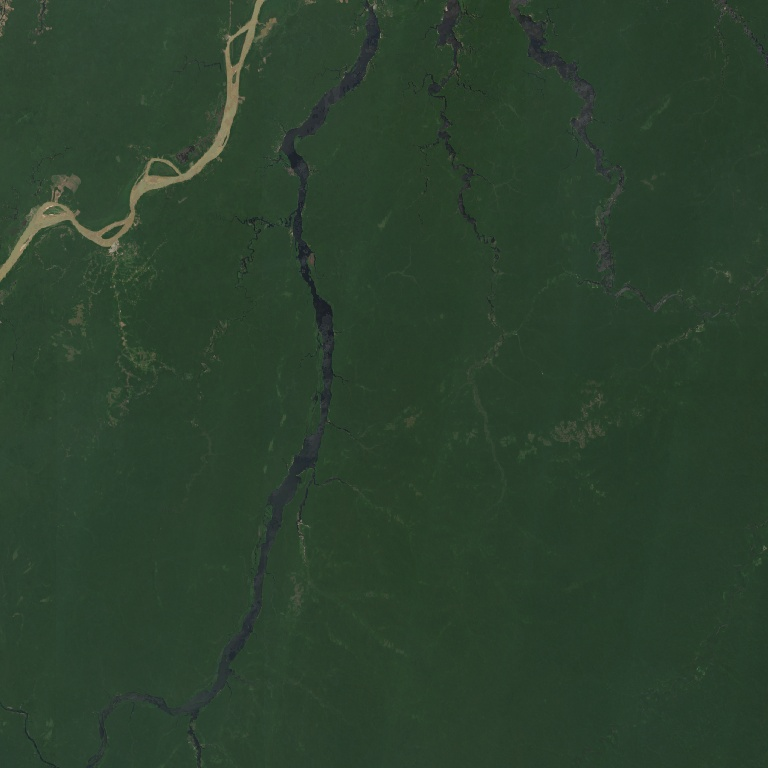

Feature extraction complete.

--- Sentinel-2 Analysis Statistics ---
{'gee_image_details': 'Median composite from COPERNICUS/S2_SR_HARMONIZED '
                      '(2023-01-01 to 2023-12-31), 79 images processed. Stats '
                      'scale: 30m. Thumb: 768x768.',
 'roi_bounds': [-59.813892, -5.253821, -58.332325, -3.983349],
 'statistics': {'B2_count': 25915242,
                'B2_max': 0.5158500075340271,
                'B2_mean': 0.027209078083764906,
                'B2_min': 0.011599999852478504,
                'B2_p2': 0.02240333108337107,
                'B2_p98': 0.040784905676365044,
                'B2_std': 0.0060870661843090024,
                'B3_count': 25915242,
                'B3_max': 0.5334500074386597,
                'B3_mean': 0.044295695792533375,
                'B3_min': 0.010999999940395355,
                'B3_p2': 0.0335910284071442,
                'B3_p98': 0.060264934707189736,
                'B3_std': 0.008733416661785403,
              

In [14]:
# ===============================================================================
# WORKFLOW 2: EXECUTION
# ===============================================================================
if DATASET_TYPE == 'sentinel2':
    print("--- Starting Sentinel-2 Workflow ---")

    # 1. Initialize GEE
    if initialize_gee():
        # 2. Fetch Data:
        gee_data_payload = fetch_sentinel2_gee_data(
            south=DEFAULT_SOUTH, north=DEFAULT_NORTH,
            west=DEFAULT_WEST, east=DEFAULT_EAST,
            start_date=DEFAULT_START_DATE, end_date=DEFAULT_END_DATE
        )

        if gee_data_payload:
            # 3. Extract Features:
            analysis_results = sentinel2_gee_extract_features(gee_data_payload, show_image=SHOW_PLOTS_INTERACTIVELY)

            if analysis_results:
                # 4. Display Statistics:
                print("\n--- Sentinel-2 Analysis Statistics ---")
                stats_to_display = {k: v for k, v in analysis_results.items() if k != 'image'}
                pprint(stats_to_display)

                # 5. Prompt LLM:
                print("\n--- Calling LLM for Interpretation ---")
                summary = call_model_responses(analysis_results, dataset_type='sentinel2')
                print("\n--- LLM Interpretation ---")
                print(summary)

    print("\n--- Sentinel-2 Workflow Finished ---")